In [9]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240407%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240407T185656Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D699b8a937fc4ce421a75d39d5d9b9b226cc409aa93de3394fcdd0c9d7d8235c9aeab9497769363c55ae6a95d94c5d03eaff6ff0ee9df4204bcc3dcf625b42f1f293c1fe45d60f7cc6bc0ec2a4f17539411c1e72b8d39413a9a7f49d38d86395c2c7d69eb7d14d461d785aaeb56b079e9c0be257f3dc6cc4a5ae91a963b81d4faefaaab6c0428b99defe6381dad4e825bfcf1fe168df7626cd538de006d9859e5bb77e2c7f675938523d538dd50dbee87565879f593bcd804016b8bbf8f087304f3e3f6ef765717a9ea849cd29d8992a95350c7c3952166d88fd68cc3300b73e6257a64f11d8d82d153d5dec3df6d3ae1c2873eb950e78a29fe6d7bfcac2fcf69'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


*I hope this notebook is somewhat useful for someone who is looking for example of simultaneous regression and classification, and multi-resoulution CNN.
I am attempting to create a mutlti-output CNN model that predicts the age and gender of an individual simultaneously.
I applied Tensorflow with Functional API that is capable to create models rather than sequential model.
In this multi-output model, I implement the network architecture of Multiresolution CNN inspired by the achievement in video classification in this CVPR paper "[1] Large-Scale Video Classification with Convolutional Neural Networks".
Besides, I inspired other UTK Face notebooks by SACHIN MEENA, SUNEEL KUMAR PATEL and ERIN WARD.*




In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model, to_categorical, load_img
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Cropping2D, Resizing, concatenate

In [11]:
BASE_DIR = '../input/utkface-new/UTKFace/'

In [12]:
# labels - age, gender
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/1_1_3_20161220143...,1,1
1,../input/utkface-new/UTKFace/15_1_0_2017010920...,15,1
2,../input/utkface-new/UTKFace/20_1_3_2017011914...,20,1
3,../input/utkface-new/UTKFace/35_0_2_2017011619...,35,0
4,../input/utkface-new/UTKFace/18_1_0_2017010921...,18,1


In [14]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

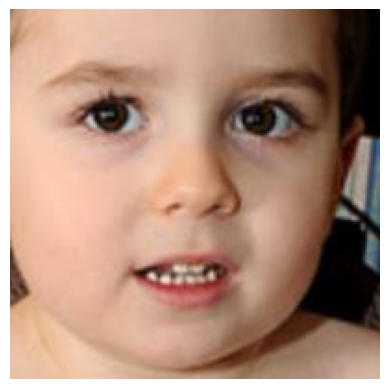

In [15]:
from PIL import Image
img = Image.open(df['image'][100])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

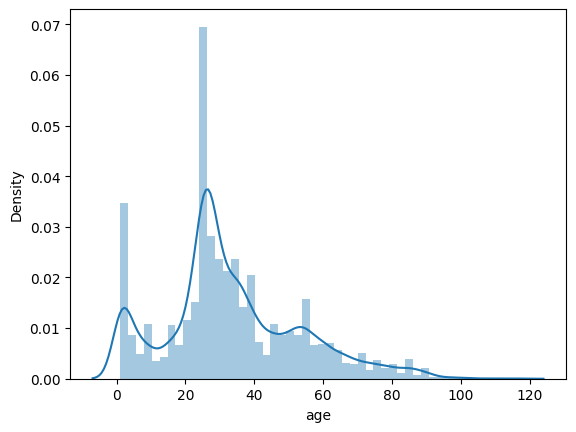

In [16]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

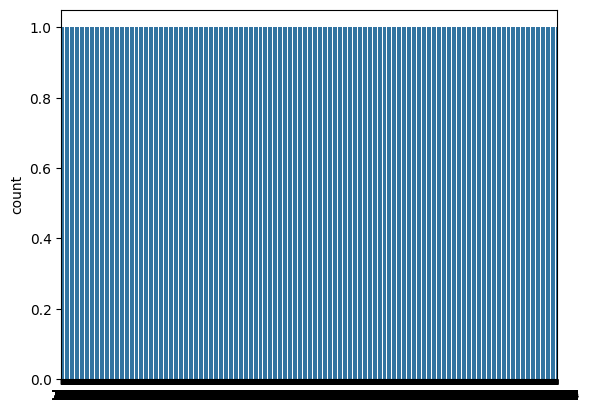

In [17]:
sns.countplot(df['gender'])

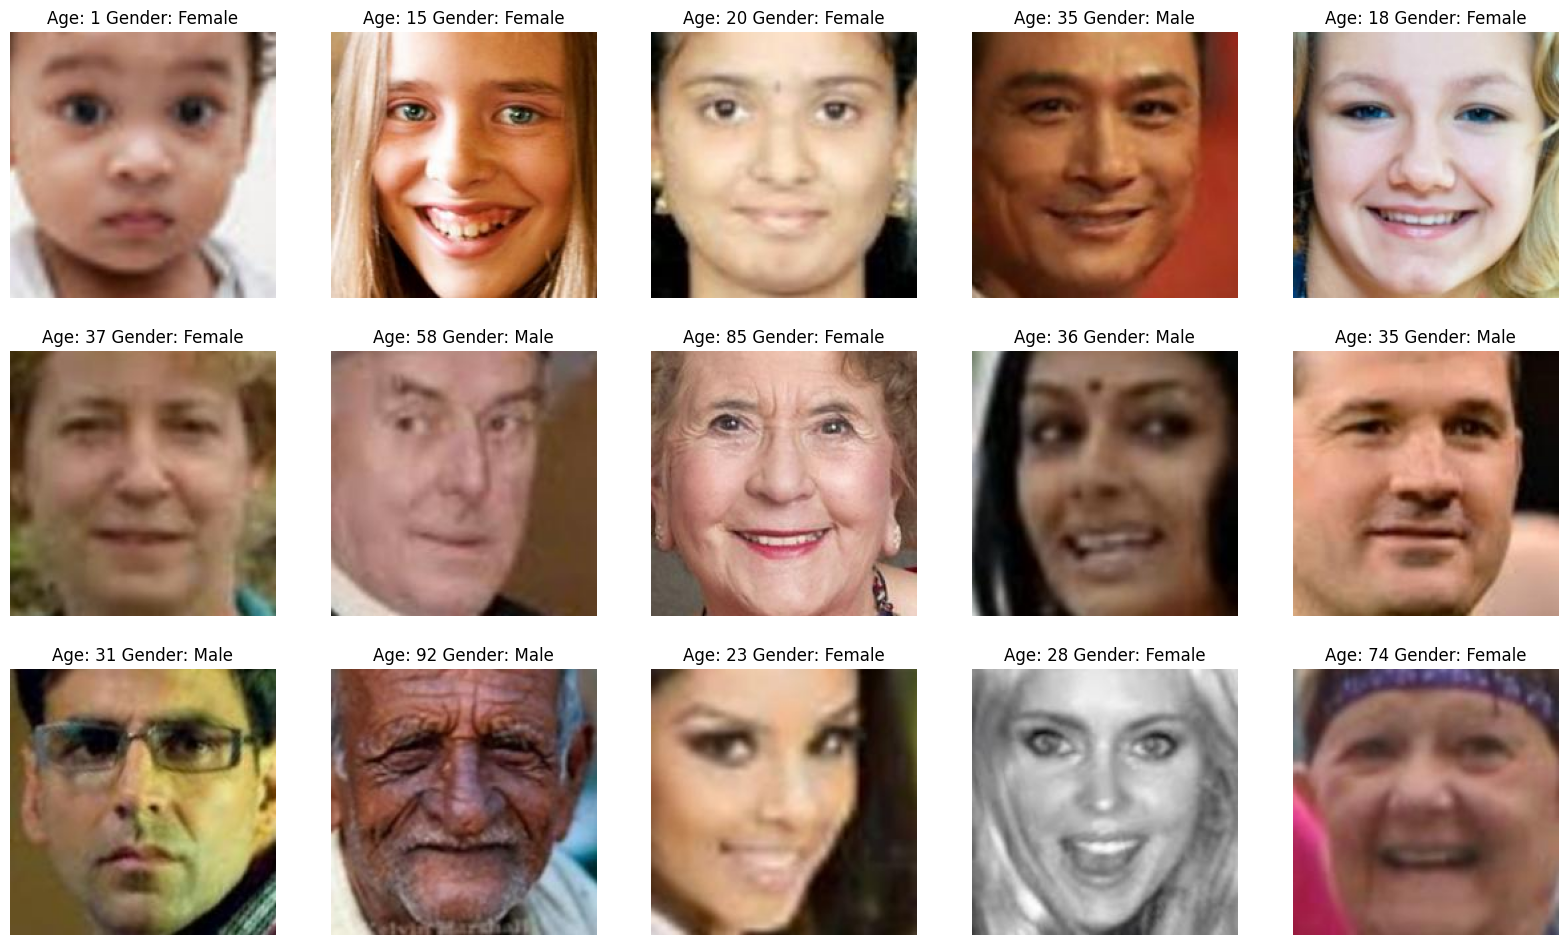

In [18]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:15]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [19]:
IMG_SIZE, CHANNEL = 128, 1
VAL_SPLIT = 0.2
LR_RATE = 2e-4
INITIAL_LEARN_RATE = 0.1
DECAY_STEP, DECAY_RATE = 1e5, 0.96
OPTIM = 0.0001
BATCH_SIZE, EPOCH = 16, 20


In [20]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), IMG_SIZE, IMG_SIZE, CHANNEL)
    return features
X = extract_features(df['image'])
X.shape

  0%|          | 0/23708 [00:00<?, ?it/s]

(23708, 128, 128, 1)

In [21]:
# normalize the images
X = X/255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (IMG_SIZE, IMG_SIZE, CHANNEL)
inputs = Input((input_shape))

*The architecture that I design here is based on CVPR paper [1]. The model uses two separate streams – ‘fovea’ and ‘context’ for learning features from different scaled-down resolutions, and concatenated later. This kind of architecture assists in shrinking the loss of important information.*

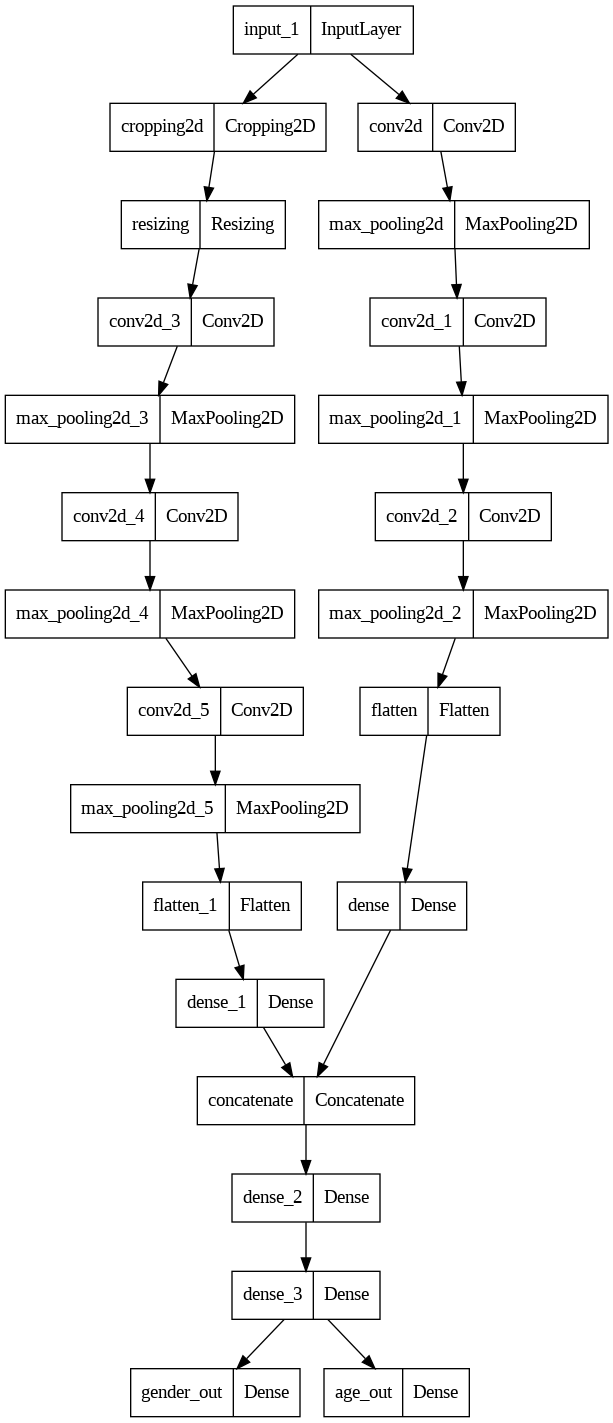

In [22]:
# Context Stream
context_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
context_pool1 = MaxPooling2D((2, 2))(context_conv1)

context_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(context_pool1)
context_pool2 = MaxPooling2D((2, 2))(context_conv2)

context_conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(context_pool2)
context_pool3 = MaxPooling2D((2, 2))(context_conv3)

context_flatten = Flatten()(context_pool3)
context_dense1 = Dense(256, activation='relu')(context_flatten)

# FOVA1 Stream with Cropping and Resizing
fova_cropped = Cropping2D(cropping=((40, 40), (40, 40)))(inputs)  # Example cropping, adjust as needed
fova_resized = Resizing(IMG_SIZE, IMG_SIZE)(fova_cropped)

fova_conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(fova_resized)
fova_pool1 = MaxPooling2D((2, 2))(fova_conv1)

fova_conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(fova_pool1)
fova_pool2 = MaxPooling2D((2, 2))(fova_conv2)

fova_conv3 = Conv2D(128, (5, 5), activation='relu', padding='same')(fova_pool2)
fova_pool3 = MaxPooling2D((2, 2))(fova_conv3)

fova_flatten = Flatten()(fova_pool3)
fova_dense1 = Dense(256, activation='relu')(fova_flatten)


# Concatenate features from different streams
merged = concatenate([context_dense1, fova_dense1])
# # Concatenate features from different streams
# merged = concatenate([context_dense1, fova_dense1])

# Fully connected layers for joint processing
x = Dense(512, activation='relu')(merged)
x = Dense(256, activation='relu')(x)

# output
output_1 = Dense(1, activation='sigmoid', name='gender_out') (x)
output_2 = Dense(1, activation='relu', name='age_out') (x)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

plot_model(model)

In [23]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)


Epoch 1/20
1186/1186 [==============================] - 42s 28ms/step - loss: 27.8822 - gender_out_loss: 0.4543 - age_out_loss: 27.4279 - gender_out_accuracy: 0.7880 - age_out_accuracy: 0.0133 - val_loss: 9.8446 - val_gender_out_loss: 0.3948 - val_age_out_loss: 9.4498 - val_gender_out_accuracy: 0.8193 - val_age_out_accuracy: 0.0491
Epoch 2/20
1186/1186 [==============================] - 30s 25ms/step - loss: 8.7403 - gender_out_loss: 0.3441 - age_out_loss: 8.3962 - gender_out_accuracy: 0.8421 - age_out_accuracy: 0.0469 - val_loss: 7.7991 - val_gender_out_loss: 0.3217 - val_age_out_loss: 7.4774 - val_gender_out_accuracy: 0.8458 - val_age_out_accuracy: 0.0491
Epoch 3/20
1186/1186 [==============================] - 31s 26ms/step - loss: 7.4923 - gender_out_loss: 0.2944 - age_out_loss: 7.1980 - gender_out_accuracy: 0.8645 - age_out_accuracy: 0.0469 - val_loss: 7.5495 - val_gender_out_loss: 0.2997 - val_age_out_loss: 7.2497 - val_gender_out_accuracy: 0.8602 - val_age_out_accuracy: 0.0491
Ep

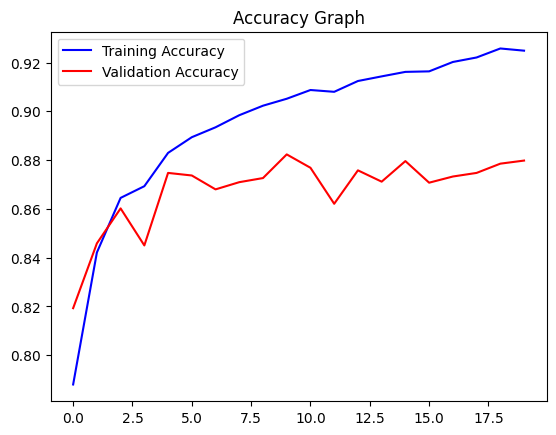

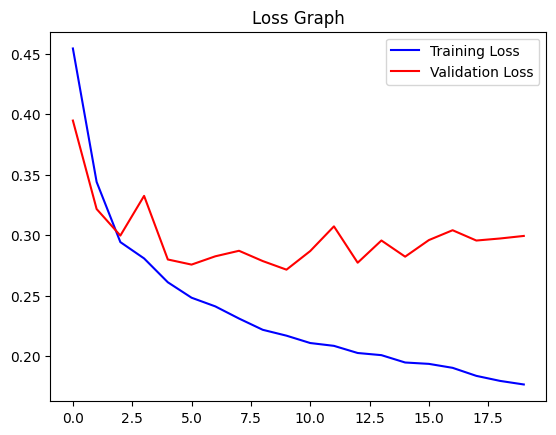

In [24]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

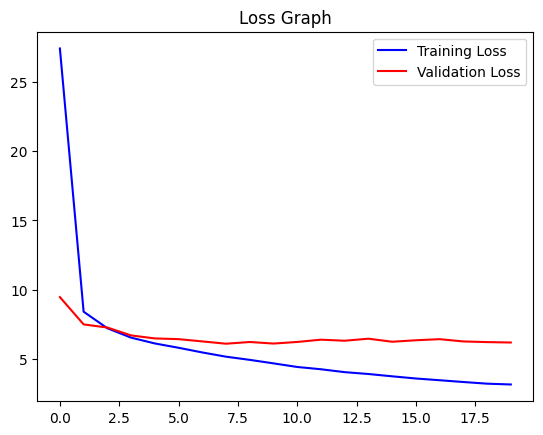

In [25]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male | Original Age: 39
1/1 [==============================] - 0s 485ms/step
Predicted Gender: Male | Predicted Age: 41


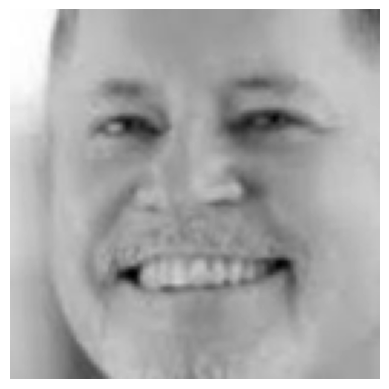

In [26]:
image_index = 900
print("Original Gender:", gender_dict[y_gender[image_index]], "| Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, IMG_SIZE, IMG_SIZE, CHANNEL))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "| Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray');

**Thank you for visiting my notebook. I hope you would enjoy. Happy Coding! **
> **Nay Chi Lynn**